In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
import pandas as pd

In [0]:
# ! {sys.executable} -m pip install kaggle --upgrade
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

Loading user credentials for kaggle

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p '{path}'  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p '{path}'
! unzip -q -n '{path}/train_v2.csv.zip' -d '{path}'
! 7za -bd -y -so x '{path}/train-jpg.tar.7z' | tar xf - -C '{path.as_posix()}'

 98% 589M/600M [00:03<00:00, 193MB/s]
100% 600M/600M [00:03<00:00, 167MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 57.2MB/s]


There are multiple tags for one image, so just measuring accuracy won't work. We'll use an accuracy threshold which would output the variables meeting a certain threshold, provided by the user.

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Putting the data inside a databunch and applying some image tranformations to augment the data. 


**Preprocessing and augmentation**


> There are couple of ways we can use to avoid overfitting; more data, augmentation, regularization and less complex model architectures. Here we will define what image augmentations to use and add them directly to our data loader. Note that if we apply augmentation here, augmentations will also be applied when we are predicting (inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions.


> The augmentations we can use for this type of data:

> * random rotation
* random crop
* random flip (horizontal and vertical both)
* random lighting
* random zoom (not implemented here)
* Gaussian blur (not implemented here)





In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.1, max_warp=0., max_rotate=15.)

In [0]:
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

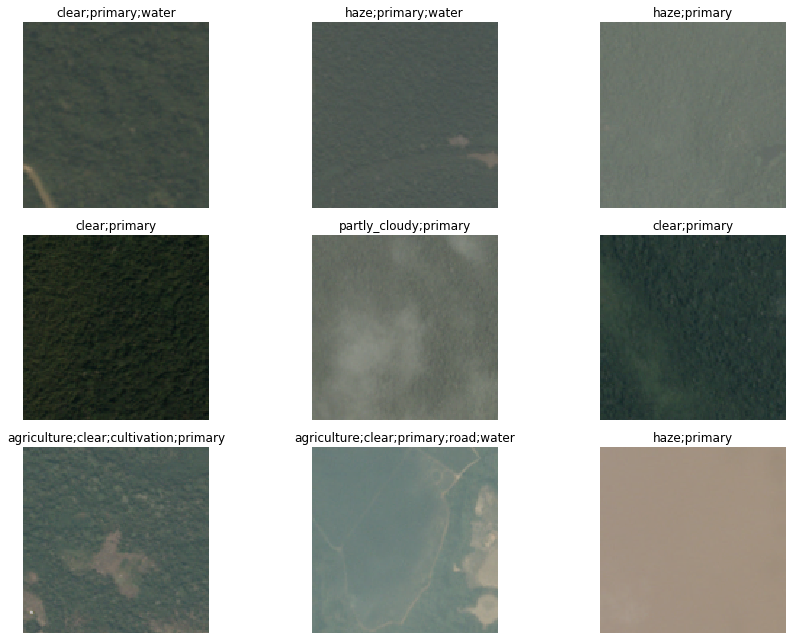

In [0]:
data.show_batch(rows=3, figsize=(12,9))

Base architecture is resnet50

In [0]:
arch = models.resnet50
acc_01 = partial(accuracy_thresh, thresh=0.1)
f_score_01 = partial(fbeta, thresh=0.1)
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score_02 = partial(fbeta, thresh=0.2)
acc_04 = partial(accuracy_thresh, thresh=0.4)
f_score_04 = partial(fbeta, thresh=0.4)
learn = cnn_learner(data, arch, metrics=[acc_01, f_score_01, acc_02, f_score_02,acc_04, f_score_04])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.1MB/s]



**fit_one_cycle:** 
This can potentially save us a lot of time from training with suboptimal hyperparameters. In addititon, Fastai library has implemented a training function for one cycle policy that we can use with only a few lines of code.

First, we find the optimal learning rate. The optimal lr is just before the base of the loss and before the start of divergence(around 1-10th of where it starts to diverge)

In [0]:
lr = 1e-1/5 #chosen from experiments in experiment notebook

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,accuracy_thresh,fbeta,accuracy_thresh,fbeta,time
0,0.134126,0.107228,0.926098,0.901763,0.947840,0.907392,0.957897,0.889339,03:41
1,0.113480,0.096356,0.936126,0.911175,0.955339,0.916214,0.963165,0.900685,03:38
2,0.103645,0.091498,0.939868,0.920541,0.957621,0.921375,0.964779,0.901987,03:37
3,0.095945,0.084868,0.938350,0.921391,0.957708,0.927148,0.967017,0.913851,03:38
4,0.090304,0.082979,0.941627,0.924324,0.959975,0.929333,0.967947,0.914557,03:40


In [0]:
learn.save('drive/My Drive/Colab Notebooks/models/stage-1-128-rn50')

In [0]:
learn.unfreeze()

We use the LR Finder to pick a good learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


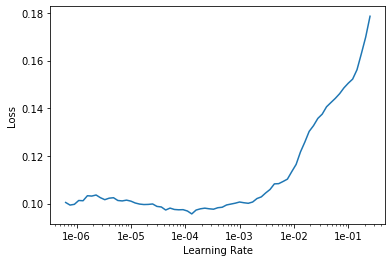

In [0]:
learn.lr_find()
learn.recorder.plot()

**Finetuning the baseline model**

Next, we can unfreeze all the trainable parameters from the model and continue its training.

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,accuracy_thresh,fbeta,accuracy_thresh,fbeta,time
0,0.096599,0.088364,0.942252,0.921707,0.958224,0.923529,0.965556,0.906209,04:26
1,0.099259,0.088416,0.934426,0.914330,0.955201,0.922671,0.965346,0.908816,04:27
2,0.093957,0.084945,0.938066,0.921535,0.957040,0.926873,0.966922,0.914360,04:28
3,0.088061,0.080420,0.941845,0.927172,0.959605,0.931311,0.968826,0.919861,04:29
4,0.081097,0.079402,0.942804,0.926270,0.959438,0.931095,0.968644,0.920542,04:28


In [0]:
learn.save('stage-2-128-rn50-lrby5')

Since, the images on which the model is trained are of size=128.
Doubling the size would make our model better as the picture quality would be higher and thus, better outputs would be obtained.

Rest of the process is same as the above processes.

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


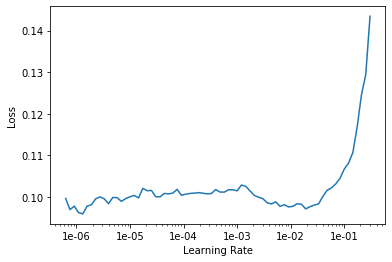

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# ! cp {path}/models/* 'drive/My Drive/Colab Notebooks/models'
# ! ls {path}/models/

stage-1-128-rn50.pth		stage-2-128-rn50-lrby5.pth	tmp.pth
stage-1-256-rn50-1e-2by1.6.pth	stage-2-256-rn50-1e-2by1.6.pth


In [0]:
lr=1e-2/1.6

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,accuracy_thresh,fbeta,accuracy_thresh,fbeta,time
0,0.092338,0.084653,0.939665,0.918951,0.955877,0.921325,0.965629,0.908409,10:45
1,0.089826,0.082886,0.943661,0.920781,0.958864,0.921764,0.966464,0.904625,10:38
2,0.087399,0.080124,0.940755,0.923383,0.958427,0.928444,0.967227,0.914188,10:38
3,0.082986,0.081205,0.942935,0.925081,0.958725,0.928523,0.967336,0.915536,10:38
4,0.086552,0.079573,0.941852,0.924472,0.958667,0.929083,0.967678,0.916078,10:37


In [0]:
learn.save('stage-1-256-rn50-1e-2by1.6')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,accuracy_thresh,fbeta,accuracy_thresh,fbeta,time
0,0.086409,0.081696,0.937063,0.920225,0.955303,0.926547,0.966450,0.915823,13:57
1,0.089135,0.082425,0.937296,0.921520,0.955652,0.926000,0.966196,0.913169,14:11
2,0.085196,0.080296,0.941416,0.924461,0.957948,0.928190,0.967634,0.917333,13:56
3,0.082278,0.079175,0.941845,0.924993,0.958769,0.929421,0.967584,0.915066,13:55
4,0.077596,0.079339,0.941714,0.924680,0.958791,0.929193,0.967656,0.916556,13:58


In [0]:
learn.save('stage-2-256-rn50-1e-2by1.6')

In [0]:
learn.export()

Submitting results to kaggle

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  


 98% 589M/603M [00:08<00:00, 110MB/s] 
100% 603M/603M [00:08<00:00, 73.3MB/s]


In [0]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

 96% 292M/304M [00:04<00:00, 33.3MB/s]
100% 304M/304M [00:04<00:00, 64.7MB/s]


In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
labelled_preds[:5]
fnames = [f.name[:-4] for f in learn.data.test_ds.items]
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
df.to_csv(path/'submission.csv', index=False)


In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "Submission 3"

100% 2.21M/2.21M [00:00<00:00, 5.51MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space